# Using the duqmap function

The api provides a map function `duqmap` which can be used to map functions over data generated by duqtools, or just data that you specify yourself (as in this example)

In [1]:
import xarray as xr

from duqtools.api import ImasHandle, Run, Runs, duqmap
from pydantic_yaml import parse_yaml_raw_as
from imas2xarray import rebase_all_coords

16:03:18 [WARNING] Python module 'omas' not found. Submodule 'jams' needs it @jams.py:14
16:03:18 [WARNING] Python module 'netCDF4' not found. Submodule 'transp' needs it @transp.py:25


## Read data from `runs.yaml`

This data is later used to instrument duqtools over which `runs` to apply the function

In [2]:
name = "../example/runs.yaml"
with open(name) as f:
    runs = parse_yaml_raw_as(Runs, f)

for run in runs:
    run.data_out.relative_location = None

## Define a function to be used with `duqmap`

Functions should have either `Run` or `ImasHandle` as the type of the first argument, `duqmap` will then take care of converting the input to the correct type

In [3]:
def print_and_return_handle(run: Run):
    print(run.dirname)
    return str(run.dirname)

this function extracts the dirnames from any runs `duqmap` operates over:

In [4]:
names = duqmap(print_and_return_handle, runs=runs)

/pfs/work/g2vazizi/jetto/runs/duqtools_experiment_0009/run_0000
/pfs/work/g2vazizi/jetto/runs/duqtools_experiment_0009/run_0001
/pfs/work/g2vazizi/jetto/runs/duqtools_experiment_0009/run_0002


A function to extract the electron temperature of each `ImasHandle` for each output mapped over by `duqmap`:

In [5]:
def extract_te(handle: ImasHandle):
    return handle.get_variables(['t_e', 'rho_tor_norm'])

Retrieve a dataset for each of the `runs` specified:

In [6]:
datasets = duqmap(extract_te, runs=runs)
datasets

[<xarray.Dataset>
 Dimensions:       (time: 1, rho_tor_norm: 101)
 Coordinates:
   * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
 Dimensions without coordinates: time
 Data variables:
     t_e           (time, rho_tor_norm) float64 7.265e+03 7.265e+03 ... 599.2,
 <xarray.Dataset>
 Dimensions:       (time: 1, rho_tor_norm: 101)
 Coordinates:
   * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
 Dimensions without coordinates: time
 Data variables:
     t_e           (time, rho_tor_norm) float64 6.054e+03 6.055e+03 ... 499.3,
 <xarray.Dataset>
 Dimensions:       (time: 1, rho_tor_norm: 101)
 Coordinates:
   * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
 Dimensions without coordinates: time
 Data variables:
     t_e           (time, rho_tor_norm) float64 4.843e+03 4.844e+03 ... 399.4]

Rebase and convert all the data into a single dataset with the help of `xarray`

In [7]:
datasets = rebase_all_coords(datasets, datasets[0])
dataset = xr.concat(datasets, dim='run')
dataset['run'] = names
dataset

<xarray.Dataset>
Dimensions:       (run: 3, time: 1, rho_tor_norm: 101)
Coordinates:
  * rho_tor_norm  (rho_tor_norm) float64 0.0 0.01 0.02 0.03 ... 0.98 0.99 1.0
  * run           (run) <U63 '/pfs/work/g2vazizi/jetto/runs/duqtools_experime...
Dimensions without coordinates: time
Data variables:
    t_e           (run, time, rho_tor_norm) float64 7.265e+03 ... 399.4

## Plot our results the way we want

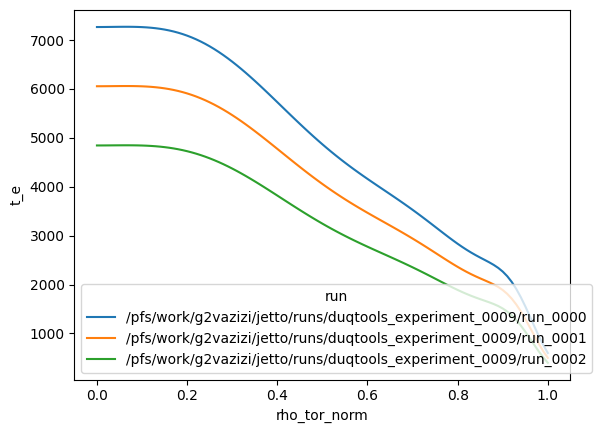

In [8]:
dataset['t_e'].isel(time=0).plot.line(x='rho_tor_norm', hue='run')